## Study of the 2D flow around a NACA wing shape

In [37]:
import lettuce as lt
import torch
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
from time import time

In [49]:
Ma = 0.1                   ## The speed of streaming
n_stream = 10              ## air should have passed the wing length n_stream-times

### APPLICATION ###
# turbine_diameter =
wing_length = 1             ## 'depth' of airfoil profile
tempC = 10                  ## degrees celcius
#p = 14.5                   ## air pressure
rho = 1.293                 ## kg/m³ air density
vchar = 5                   ## usually medium streaming velocity (may also be maximum velocity, around 1.5-times)
                            ## large wind turbines produce maximum power at 15 m/s. This can be assumed to be streaming velocity around the centre
dt_pu = 1e-5                ## this should allow up to 25,000 Hz

### DOMAIN ###
nx = 600                   ## number of lattice nodes in x-direction
ny = 150                    ## number of lattice nodes in y-direction
# shape = (nx, ny)            ## domain shape
x_wing_nose = 1             ## physical space before wing
x_wing_tail = 3             ## physical space behind wing
chord_length = wing_length  ## physical length of wing
domain_length_x = x_wing_nose + wing_length + x_wing_tail
dx = domain_length_x/nx     ## i.e. resolution
n_wing_nose = int(x_wing_nose//dx)  ## first grid point with wing
n_wing_tail = int(x_wing_tail//dx)  ## first grid point with wing

### FLOW CHARACTERISTICS ###
#Re = 5e6
lchar = wing_length         ## characteristic length in pu is obstacle length
temp = tempC+273.15         ## temperature in Kelvin
visc_dyn = 2.791e-7*temp**0.7355 ## dynamic viscosity of air
visc_kin = visc_dyn/rho     ## kinematic viscosity of air
Re = vchar*lchar/visc_kin   ## The type of streaming around the foil. Small (1.5m) 8e3,medium (3-5m) 2e5, large (>5m-150m) up to 5e6

# number of steps depends on Mach number and resolution (?)
#nmax = 100000
t_max = wing_length/vchar*n_stream   ## simulate tmax-seconds

### SIMULATION PARAMETERS ##
# how often to report (every n simulation steps)
nreport = 500
# how often to print (every n simulation steps)
nconsole = 2000
# how often to plot (every n console steps)
nplot = 5
# test for convergence and crash
test_iterations = True
test_convergence = False
epsilon = 1e-7
# run pre-simulation with low Re to get rid of initialization pulses
Re_pre = 1000
n_pre = 2000  # wing profiles with camber may crash at low Re

### LETTUCE PARAMETERS ###
lattice = lt.Lattice(lt.D2Q9, torch.device("cuda:0"), use_native=False)


In [50]:
def mask_from_csv(x, y, wing_name):
    mask_shape = np.shape(x)
    nx1, ny1 = mask_shape
    dx = domain_length_x/nx1     ## i.e. resolution
    n_wing_nose = int(x_wing_nose//dx)  ## first grid point with wing
    n_wing_tail = int(x_wing_tail//dx)  ## first grid point with wing
    #n_wing_nose = int(nx1//5)    # wing starts after 1/5 of domain length
    #n_wing_tail = int(nx1*3//5)  # wing goes until 3/5 of domain length
    n_wing_height = int(ny1//2)  # wing sits at middle of domain length

    # read wing data from http://airfoiltools.com/plotter/index
    surface_data = np.genfromtxt(wing_name+'.csv', delimiter=",")[9:,:]
    surface_data = surface_data[:np.min(np.where(np.isnan(surface_data)[:,1])),:]
    zero_row = np.where(surface_data[:,0]==0)[0][0]
    x_data_top, y_data_top = surface_data[:zero_row,:].transpose()
    x_data_bottom, y_data_bottom = surface_data[zero_row:,:].transpose()

    # calculate scaling factor
    #x_wing_nose = x[n_wing_nose,0]
    #x_wing_tail = x[n_wing_tail,0]
    #available_length_x = x_wing_tail - x_wing_nose
    available_length_n = n_wing_tail-n_wing_nose
    actual_wing_length_x = max(max(x_data_top), max(x_data_bottom))
    scaling_factor = wing_length / actual_wing_length_x

    # scale wing data to fit domain restrictions
    x_data_top *= scaling_factor
    x_data_bottom *= scaling_factor
    y_data_top *= scaling_factor
    y_data_bottom *= scaling_factor

    # mapping data to the grid
    x_data_interp        = np.linspace(0, wing_length, available_length_n)            # [0 ... 5.05]
    y_data_top_interp    = interpolate.interp1d(x_data_top, y_data_top, fill_value="extrapolate")(x_data_interp)       # .interp1d object
    y_data_bottom_interp = interpolate.interp1d(x_data_bottom, y_data_bottom, fill_value="extrapolate")(x_data_interp) # .interp1d object

    # shifting the wing up by half the grid
    y_wing_height = y[0, n_wing_height]
    y_data_top_interp += y_wing_height
    y_data_bottom_interp += y_wing_height

    # setting y data in a 2D grid to compare with flow.grid[1]
    y_data_top_mapped = np.zeros(mask_shape)
    y_data_top_mapped[n_wing_nose:n_wing_tail, :] = np.array([y_data_top_interp]).transpose()
    y_data_bottom_mapped = np.zeros(mask_shape)
    y_data_bottom_mapped[n_wing_nose:n_wing_tail, :] = np.array([y_data_bottom_interp]).transpose()

    # creating mask
    bool_mask = (y < y_data_top_mapped) & (y > y_data_bottom_mapped)
    return bool_mask

In [51]:
# class NacaWithPre(lt.Obstacle):
#     def __init__(self, wing_name, file_name=None):
#         if file_name is None:
#             self.filename_base = r"/media/philipp/Storage/data/"+wing_name
#         else:
#             self.filename_base = r"/media/philipp/Storage/data/"+file_name+'_pre'
#         self.wing_name = wing_name
#         self.n_pre = n_pre
#         self.lattice = lattice
#         super(NacaWithPre, self).__init__(shape, reynolds_number=Re, mach_number=Ma,lattice=lattice,domain_length_x=domain_length_x)
#         x, y = self.grid
#         self.mask = mask_from_csv(x, y, wing_name)
#         self.pre_flow = lt.Obstacle(shape,reynolds_number=Re_pre,mach_number=Ma,lattice=lattice,domain_length_x=domain_length_x)
#         self.pre_flow.mask = self.mask
#
#     def initial_solution(self, x):
#         # run a bit with low Re
#         print('Doing ', n_pre, ' steps with Re = ', Re_pre, ' before actual run.')
#         simulation = lt.Simulation(self.pre_flow, self.lattice, lt.RegularizedCollision(lattice, self.units.relaxation_parameter_lu),lt.StandardStreaming(lattice))
#         print("total pre-time: ", self.pre_flow.units.convert_time_to_pu(self.n_pre))
#         simulation.initialize_f_neq()
#         simulation.reporters.append(lt.ObservableReporter(lt.IncompressibleKineticEnergy(lattice, self.pre_flow), interval=nconsole)) # print energy
#         simulation.reporters.append(lt.VTKReporter(lattice, self.pre_flow, interval=nreport, filename_base=self.filename_base))
#         simulation.step(self.n_pre)
#         p = simulation.flow.units.convert_density_lu_to_pressure_pu(simulation.lattice.rho(simulation.f))
#         u = self.pre_flow.units.convert_velocity_to_pu(lattice.u(simulation.f))
#         return p, u

In [52]:
class Naca(lt.Obstacle):
    def __init__(self, wing_name, re_number, shape):
        super(Naca, self).__init__(shape, reynolds_number=re_number, mach_number=Ma,lattice=lattice,domain_length_x=domain_length_x,char_length=chord_length,char_velocity=vchar)
        x, y = self.grid
        self.mask = mask_from_csv(x, y, wing_name)

In [53]:
def setup_simulation(wing_name, file_name=None, tmax=t_max, re_number=Re, n_x=nx, n_y=ny):
    if file_name is None:
        filename_base = r"/media/philipp/Storage/data/"+wing_name
    else:
        filename_base = r"/media/philipp/Storage/data/"+file_name
    shape = (n_x, n_y)
    print('shape = ', shape)
    flow = Naca(wing_name, re_number, shape)
    simulation = lt.Simulation(flow, lattice, lt.KBCCollision2D(lattice, flow.units.relaxation_parameter_lu),
                        lt.StandardStreaming(lattice))
    nmax = flow.units.convert_time_to_lu(tmax)
    print("Doing up to ", "{:.2e}".format(nmax), " steps.")
    print("Key paramters: run name:", file_name, ", chord length", chord_length, "[m], Re", "{:.2e}".format(re_number), "[1]")
    print("I will record every", nreport, "-th step, print every", nconsole, "-th step, and plot every", nconsole*nplot, "-th step.\n",
          "1000 steps correspond to", tmax/nmax*1e3, "seconds.\n")

    # set up reporters
    Energy = lt.IncompressibleKineticEnergy(lattice, flow)
    #energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
    #simulation.reporters.append(energy_reporter_internal)
    simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
    simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base=filename_base))
    return simulation, flow, Energy, nmax

def run_n_plot(simulation, flow, Energy, nmax):
    # initialize simulation
    simulation.initialize_f_neq()
    if test_iterations:
        energy_new = 0
        mlups = 0
        iterations = int(nmax//nconsole)
        for i in range(iterations):
            mlups += simulation.step(nconsole)
            energy_old = energy_new
            energy_new = Energy(simulation.f).mean().item()
            rchange = abs((energy_new - energy_old)/energy_new)
            print("avg MLUPS: ", mlups/(i+1))
            if test_convergence and rchange < epsilon:
                print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
                break
            elif test_convergence:
                print("no convergence, still ", round(rchange*100,5), " % relative change")
            elif not energy_new == energy_new:
                print("CRASHED!")
                break
            if i%nplot == 0:
                u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
                plt.imshow(u[0,...].T, origin="lower")
                plt.show()
        u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
        plt.imshow(u[0,...].T, origin="lower")
        plt.show()
    else:
        mlups = simulation.step(nmax)
        print("MLUPS: ", mlups)
        u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
        plt.imshow(u[0,...].T, origin="lower")
        plt.show()
    return

In [56]:
wing_dict = {
    'NACA-63215-highAOA',
    'NACA-63215-lowAOA',
    'NACA-63215-noAOA',
    'NACA-0012-lowAOA',
    'NACA-0012-noAOA'
}
re_dict = {
    1e3,
    1e4,
    1e5,
    1e6,
    1e7
}
res_dict = {
    100,
    200,
    300,
    400,
    500,
    600
}
# Re -> vchar -> nmax

setup = {}
# do comparison of resolution
for ny in res_dict:
    name = 'NACA-0012-lowAOA'
    run_name = name+'_ny'+str(ny)
    setup[run_name] = setup_simulation(name, run_name, tmax=wing_length/vchar*n_stream, re_number=Re, n_x=4*ny, n_y=ny)
# do comparison of wings and reynolds numbers
# for name in wing_dict:
#     for Re in re_dict:
#         vchar = Re*visc_kin/lchar
#         run_name = name+'_Re'+"{:.2e}".format(Re)
#         setup[run_name] = setup_simulation(name, run_name, tmax=wing_length/vchar*n_stream, re_number=Re)

shape =  (1600, 400)
Doing up to  5.54e+04  steps.
Key paramters: run name: NACA-0012-lowAOA_ny400 , chord length 1 [m], Re 3.64e+05 [1]
I will record every 500 -th step, print every 2000 -th step, and plot every 10000 -th step.
 1000 steps correspond to 0.03608439182435162 seconds.

steps     time     IncompressibleKineticEnergy
shape =  (400, 100)
Doing up to  1.39e+04  steps.
Key paramters: run name: NACA-0012-lowAOA_ny100 , chord length 1 [m], Re 3.64e+05 [1]
I will record every 500 -th step, print every 2000 -th step, and plot every 10000 -th step.
 1000 steps correspond to 0.1443375672974065 seconds.

steps     time     IncompressibleKineticEnergy
shape =  (2000, 500)
Doing up to  6.93e+04  steps.
Key paramters: run name: NACA-0012-lowAOA_ny500 , chord length 1 [m], Re 3.64e+05 [1]
I will record every 500 -th step, print every 2000 -th step, and plot every 10000 -th step.
 1000 steps correspond to 0.028867513459481298 seconds.

steps     time     IncompressibleKineticEnergy
shape

0 0.0 0.0
2000 0.07216878364870324 22.938751220703125
avg MLUPS:  63.797080291787225


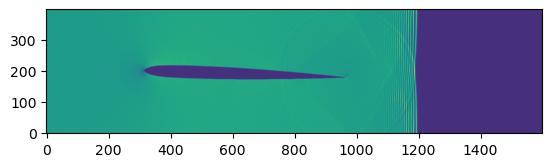

4000 0.1443375672974065 70.8580093383789
avg MLUPS:  64.20598813674329
6000 0.2165063509461097 120.07462310791016
avg MLUPS:  64.34432278431088
8000 0.288675134594813 97.31983184814453
avg MLUPS:  64.42230094527875
10000 0.3608439182435162 82.78083801269531
avg MLUPS:  64.66999158999774
12000 0.4330127018922194 74.01561737060547
avg MLUPS:  64.82259572945425


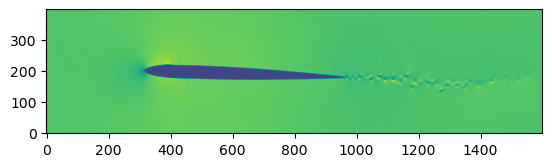

14000 0.5051814855409227 78.59333038330078
avg MLUPS:  64.9254306952552
16000 0.577350269189626 81.19385528564453
avg MLUPS:  64.97060074128059
18000 0.6495190528383291 82.47272491455078
avg MLUPS:  64.94416973535425
20000 0.7216878364870324 81.34295654296875
avg MLUPS:  64.93034091297508
22000 0.7938566201357355 80.84135437011719
avg MLUPS:  64.93795167688403


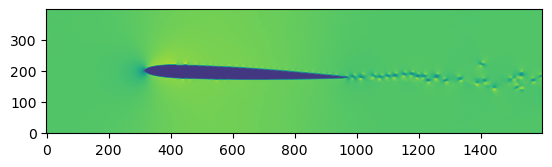

24000 0.8660254037844388 80.74162292480469
avg MLUPS:  65.0070373562218
26000 0.9381941874331421 81.0103988647461
avg MLUPS:  65.07894457476127
28000 1.0103629710818454 81.14871978759766
avg MLUPS:  65.11148295047072
30000 1.0825317547305484 81.13029479980469
avg MLUPS:  65.09393746503298
32000 1.154700538379252 81.07597351074219
avg MLUPS:  65.07832059491827


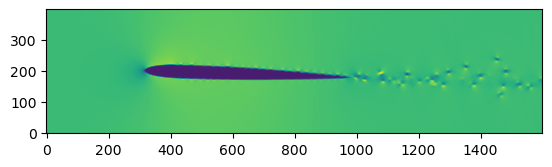

34000 1.2268693220279552 81.08157348632812
avg MLUPS:  65.12149945610754
36000 1.2990381056766582 81.07490539550781
avg MLUPS:  65.15966084172184
38000 1.3712068893253615 81.09638214111328
avg MLUPS:  65.187259348125
40000 1.4433756729740648 81.10694122314453
avg MLUPS:  65.24562401920039
42000 1.515544456622768 81.11732482910156
avg MLUPS:  65.42497544272095


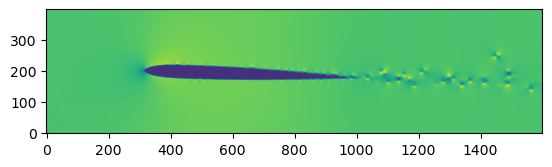

44000 1.587713240271471 81.127685546875
avg MLUPS:  65.60732330275253
46000 1.6598820239201744 81.09628295898438
avg MLUPS:  65.8517928112967
48000 1.7320508075688776 81.09343719482422
avg MLUPS:  66.0760658492379
50000 1.8042195912175811 81.11083984375
avg MLUPS:  66.28307172196648
52000 1.8763883748662842 81.10240173339844
avg MLUPS:  66.4741143879763


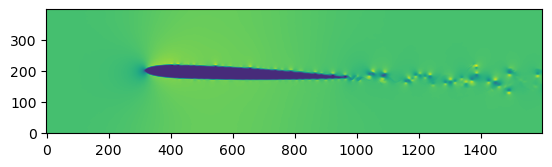

54000 1.9485571585149875 81.1393814086914
avg MLUPS:  66.6508420288209


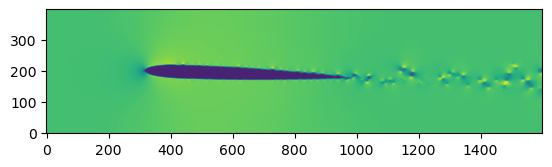

NACA-0012-lowAOA_ny400  took  519.8151965141296  s

0 0.0 0.0
2000 0.288675134594813 97.47793579101562
avg MLUPS:  22.293951344830194


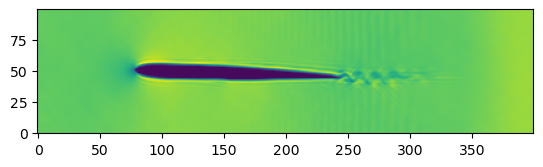

4000 0.577350269189626 81.81169128417969
avg MLUPS:  22.27471823337831
6000 0.8660254037844388 81.54283142089844
avg MLUPS:  22.30079955419393
8000 1.154700538379252 82.11550903320312
avg MLUPS:  22.32506326727246
10000 1.4433756729740648 82.21837615966797
avg MLUPS:  22.334285702397494
12000 1.7320508075688776 82.43965911865234
avg MLUPS:  22.339287997554276


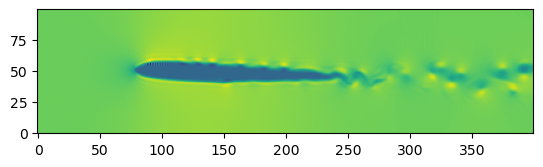

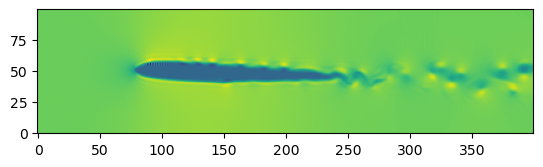

NACA-0012-lowAOA_ny100  took  21.671026706695557  s

0 0.0 0.0
2000 0.05773502691896259 17.83747100830078
avg MLUPS:  69.77437457092408


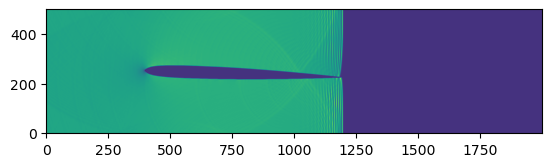

4000 0.11547005383792518 46.741092681884766
avg MLUPS:  69.88325449059906
6000 0.17320508075688779 94.04224395751953
avg MLUPS:  69.95097367613653
8000 0.23094010767585035 115.85648345947266
avg MLUPS:  69.97579890634651
10000 0.288675134594813 97.31282806396484
avg MLUPS:  69.98251042714945
12000 0.34641016151377557 85.11396789550781
avg MLUPS:  69.99952658249613


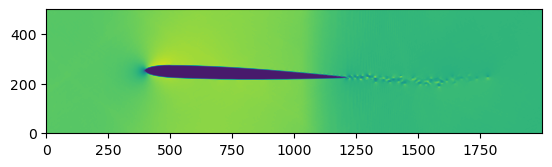

14000 0.40414518843273817 73.7269287109375
avg MLUPS:  69.85186367027967
16000 0.4618802153517007 75.5881576538086
avg MLUPS:  69.59047862886851
18000 0.5196152422706634 79.25103759765625
avg MLUPS:  69.06655120474491
20000 0.577350269189626 81.16060638427734
avg MLUPS:  68.50136391029244
22000 0.6350852961085884 82.58837890625
avg MLUPS:  68.28364836357888


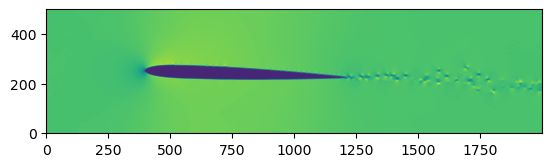

24000 0.6928203230275511 81.7115478515625
avg MLUPS:  68.13811882061789
26000 0.7505553499465137 81.14398956298828
avg MLUPS:  68.04329919618523
28000 0.8082903768654763 80.64334869384766
avg MLUPS:  67.59161048491548
30000 0.8660254037844388 80.70050048828125
avg MLUPS:  67.63566860123937
32000 0.9237604307034014 80.96654510498047
avg MLUPS:  67.6574405673066


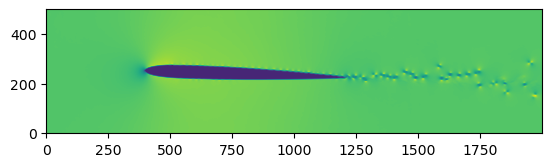

34000 0.981495457622364 81.03083801269531
avg MLUPS:  67.63049974553441
36000 1.0392304845413267 81.10863494873047
avg MLUPS:  67.68308625101031
38000 1.0969655114602892 81.06859588623047
avg MLUPS:  67.69357350390025
40000 1.154700538379252 81.03810119628906
avg MLUPS:  67.64530683076401
42000 1.2124355652982144 81.02226257324219
avg MLUPS:  67.67765927647523


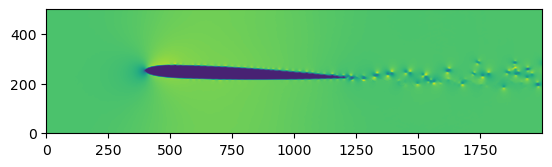

44000 1.2701705922171769 81.0096664428711
avg MLUPS:  67.69660241314212
46000 1.3279056191361396 81.02680206298828
avg MLUPS:  67.77454561012583
48000 1.3856406460551023 81.05709075927734
avg MLUPS:  67.74694552955103
50000 1.4433756729740648 81.04542541503906
avg MLUPS:  67.62448355057676
52000 1.5011106998930275 81.04107666015625
avg MLUPS:  67.51338911806997


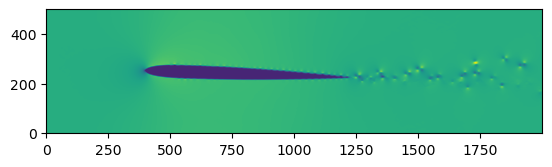

54000 1.55884572681199 81.06253814697266
avg MLUPS:  67.409841249645
56000 1.6165807537309527 81.0486068725586
avg MLUPS:  67.31202316278403
58000 1.6743157806499154 81.04158020019531
avg MLUPS:  67.21623653187946
60000 1.7320508075688776 81.0763931274414
avg MLUPS:  67.11981108817604
62000 1.7897858344878401 81.0574951171875
avg MLUPS:  67.03634204129384


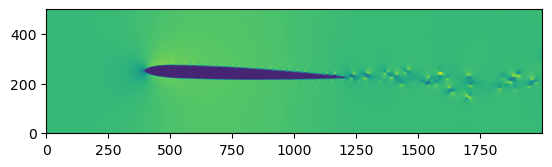

64000 1.8475208614068028 81.04931640625
avg MLUPS:  66.9528272511161
66000 1.9052558883257653 81.05438232421875
avg MLUPS:  66.87361128997004
68000 1.962990915244728 81.06410217285156
avg MLUPS:  66.7641815661796


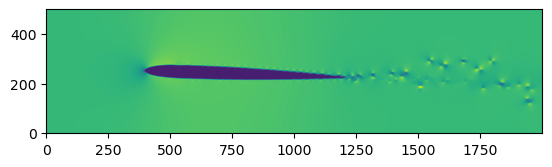

NACA-0012-lowAOA_ny500  took  1020.6733615398407  s

0 0.0 0.0
2000 0.1443375672974065 70.88209533691406
avg MLUPS:  62.5705467761067


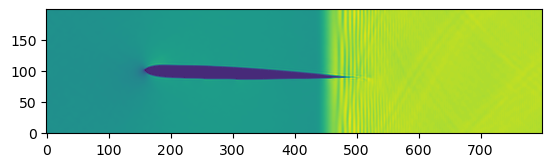

4000 0.288675134594813 97.3846435546875
avg MLUPS:  62.71591140353806
6000 0.4330127018922194 74.19156646728516
avg MLUPS:  62.77960956748859
8000 0.577350269189626 81.38037872314453
avg MLUPS:  62.86003985679831
10000 0.7216878364870324 81.55404663085938
avg MLUPS:  62.82840698241546
12000 0.8660254037844388 81.01310729980469
avg MLUPS:  62.808283170168494


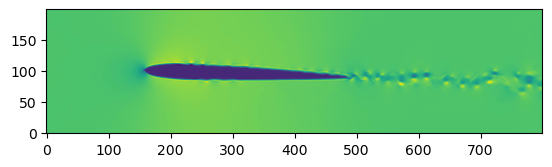

14000 1.0103629710818454 81.40775299072266
avg MLUPS:  62.8173041853319
16000 1.154700538379252 81.37971496582031
avg MLUPS:  62.797546824948384
18000 1.2990381056766582 81.40203857421875
avg MLUPS:  62.80669389995483
20000 1.4433756729740648 81.44874572753906
avg MLUPS:  62.8135074216155
22000 1.587713240271471 81.43817901611328
avg MLUPS:  62.81302369344164


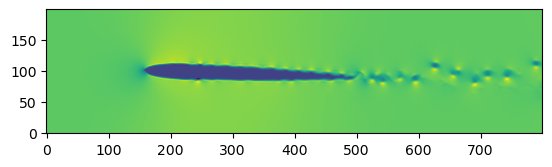

24000 1.7320508075688776 81.50786590576172
avg MLUPS:  62.80553520387815
26000 1.8763883748662842 81.51316833496094
avg MLUPS:  62.80775138651397


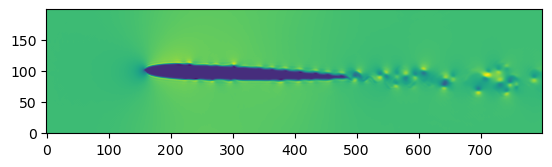

NACA-0012-lowAOA_ny200  took  66.50800657272339  s

0 0.0 0.0
2000 0.04811252243246883 14.544670104980469
avg MLUPS:  62.87686736274529


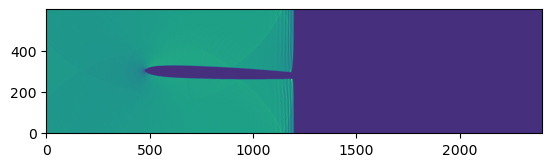

4000 0.09622504486493766 31.275663375854492
avg MLUPS:  63.163454647523224
6000 0.1443375672974065 70.87330627441406
avg MLUPS:  63.28768820979223
8000 0.19245008972987532 109.53831481933594
avg MLUPS:  63.44106212332132
10000 0.24056261216234415 113.01041412353516
avg MLUPS:  63.76564204804631
12000 0.288675134594813 97.31658935546875
avg MLUPS:  63.75992938534238


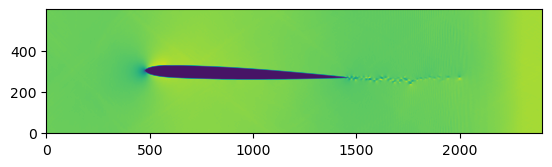

14000 0.3367876570272818 86.69637298583984
avg MLUPS:  63.76810682362768
16000 0.38490017945975064 77.87702941894531
avg MLUPS:  63.898124075079096
18000 0.4330127018922194 73.97146606445312
avg MLUPS:  64.06455253938837
20000 0.4811252243246883 76.95428466796875
avg MLUPS:  63.70610261446202
22000 0.5292377467571571 79.59488677978516
avg MLUPS:  63.81737502224366


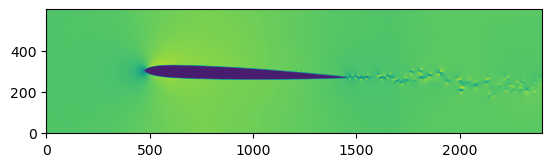

24000 0.577350269189626 81.15107727050781
avg MLUPS:  63.8788366450112
26000 0.6254627916220947 82.68326568603516
avg MLUPS:  63.925484109619745
28000 0.6735753140545636 82.05744934082031
avg MLUPS:  63.95546342667268
30000 0.7216878364870324 81.29985809326172
avg MLUPS:  63.95393869438919
32000 0.7698003589195013 81.0440444946289
avg MLUPS:  63.712411280476395


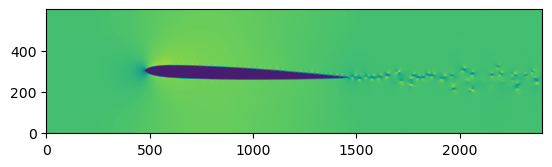

34000 0.81791288135197 80.5797119140625
avg MLUPS:  63.77995147889965
36000 0.8660254037844388 80.69055938720703
avg MLUPS:  63.844558818159804
38000 0.9141379262169077 80.90705108642578
avg MLUPS:  63.994834846138474
40000 0.9622504486493766 80.97722625732422
avg MLUPS:  64.08101554147919
42000 1.0103629710818454 81.07923889160156
avg MLUPS:  64.22227265123323


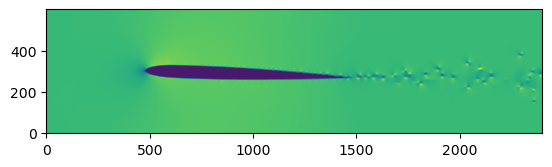

44000 1.0584754935143141 81.0700912475586
avg MLUPS:  64.2559242132984
46000 1.106588015946783 81.030517578125
avg MLUPS:  64.27998871544341
48000 1.154700538379252 81.01280212402344
avg MLUPS:  64.40347738228202
50000 1.2028130608117207 81.00236511230469
avg MLUPS:  64.51337650121522
52000 1.2509255832441895 80.99308013916016
avg MLUPS:  64.60046648302549


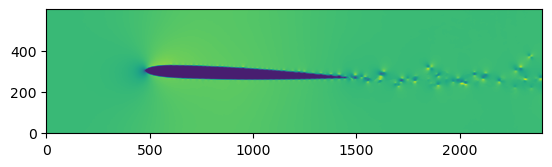

54000 1.2990381056766582 80.99996948242188
avg MLUPS:  64.69539023892044
56000 1.3471506281091272 81.01826477050781
avg MLUPS:  64.79104812611793
58000 1.395263150541596 81.02914428710938
avg MLUPS:  64.88955012745848
60000 1.4433756729740648 81.02296447753906
avg MLUPS:  64.9829151494515
62000 1.4914881954065335 81.01522827148438
avg MLUPS:  64.98263393320858


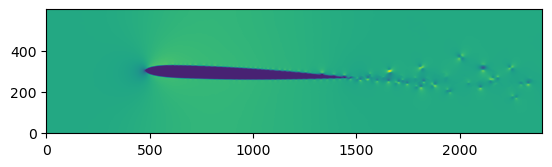

64000 1.5396007178390025 81.022216796875
avg MLUPS:  64.97929260185332
66000 1.587713240271471 81.0479965209961
avg MLUPS:  65.04005324032417
68000 1.63582576270394 81.0274658203125
avg MLUPS:  65.09425124784501
70000 1.683938285136409 81.01934814453125
avg MLUPS:  65.05175149123193
72000 1.7320508075688776 81.00582122802734
avg MLUPS:  65.07871166967078


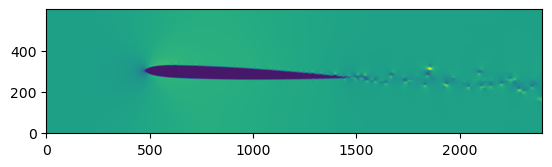

74000 1.7801633300013464 81.01583862304688
avg MLUPS:  65.11146461635222
76000 1.8282758524338154 81.0180435180664
avg MLUPS:  65.16305983125554
78000 1.8763883748662842 81.0231704711914
avg MLUPS:  65.21594559308225
80000 1.9245008972987532 81.04562377929688
avg MLUPS:  65.27309195421357
82000 1.9726134197312217 81.00111389160156
avg MLUPS:  65.3738935863558


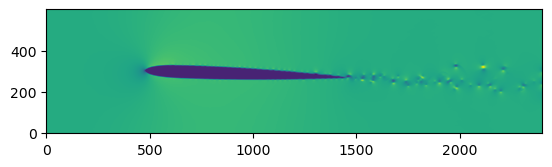

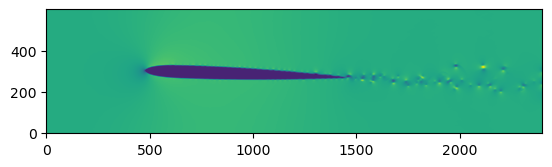

NACA-0012-lowAOA_ny600  took  1808.8751895427704  s

0 0.0 0.0
2000 0.09622504486493766 31.31538963317871
avg MLUPS:  71.85100411754621


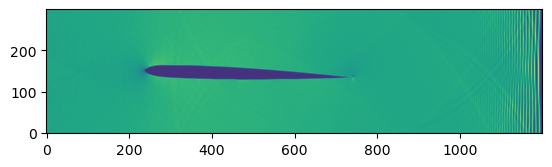

4000 0.19245008972987532 109.46643829345703
avg MLUPS:  72.06043585661027
6000 0.288675134594813 97.34983825683594
avg MLUPS:  72.0684863180082
8000 0.38490017945975064 77.9704360961914
avg MLUPS:  72.13689977367805
10000 0.4811252243246883 77.060546875
avg MLUPS:  72.17998339403053
12000 0.577350269189626 81.2602310180664
avg MLUPS:  72.03087787578225


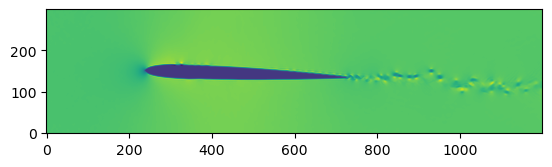

14000 0.6735753140545636 82.16915130615234
avg MLUPS:  71.90685862017114
16000 0.7698003589195013 81.1741714477539
avg MLUPS:  71.77635001550573
18000 0.8660254037844388 80.84430694580078
avg MLUPS:  71.79523840529217
20000 0.9622504486493766 81.1266860961914
avg MLUPS:  71.6457772503372
22000 1.0584754935143141 81.24401092529297
avg MLUPS:  71.63695800455979


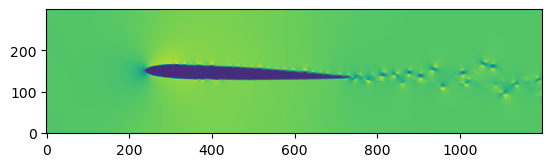

24000 1.154700538379252 81.19011688232422
avg MLUPS:  71.51300987950452
26000 1.2509255832441895 81.17903137207031
avg MLUPS:  71.47716613693821
28000 1.3471506281091272 81.22623443603516
avg MLUPS:  71.4522836558485
30000 1.4433756729740648 81.23912811279297
avg MLUPS:  71.43027764929035
32000 1.5396007178390025 81.24376678466797
avg MLUPS:  71.36742197869384


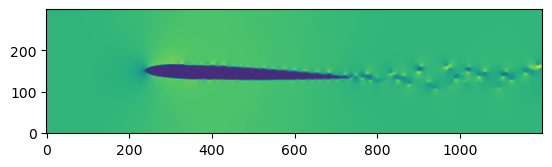

34000 1.63582576270394 81.22565460205078
avg MLUPS:  71.3442151968866
36000 1.7320508075688776 81.21823120117188
avg MLUPS:  71.27786232795637
38000 1.8282758524338154 81.25116729736328
avg MLUPS:  71.25295625609243
40000 1.9245008972987532 81.26998138427734
avg MLUPS:  71.30619693974243


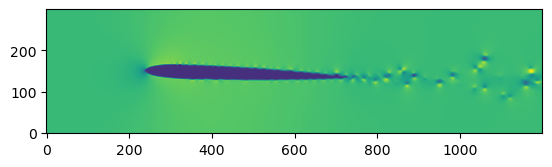

NACA-0012-lowAOA_ny300  took  202.30633568763733  s



In [57]:
for run_name in setup:
    t = time()
    [sim, flo, Ener, n_max] = setup[run_name]
    run_n_plot(sim, flo, Ener, n_max)
    print(run_name, " took ", time()-t, " s\n")